# Comprehensive Trend-Following Demo

This notebook demonstrates the end-to-end capabilities of the systematic trend-following
research platform. It walks through data preparation, core backtesting, rich analytics,
parameter studies, walk-forward validation, and robustness tooling that map directly to
the nine implementation phases outlined in the project specification.

## Notebook Outline

1. Environment setup and configuration loading.
2. Market data preparation and validation checks.
3. Baseline backtest with performance analytics.
4. Attribution, exposure, and diagnostic visualisations.
5. Parameter sweeps and sensitivity studies.
6. Walk-forward evaluation.
7. Monte-Carlo robustness analysis.
8. Summary of generated artefacts and next steps.

In [ ]:
from __future__ import annotations

from pathlib import Path

REPO_ROOT = Path.cwd().resolve()
while not (REPO_ROOT / "pyproject.toml").exists():
    if REPO_ROOT.parent == REPO_ROOT:
        raise RuntimeError("Run this notebook from within the repository tree")
    REPO_ROOT = REPO_ROOT.parent

print(f"Repository root: {REPO_ROOT}")

In [2]:
%pip install -q   n 3-e "{REPO_ROOT}"

Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import pandas as pd

plt.style.use("seaborn-v0_8")
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:,.4f}".format

## 1. Load configuration, universe metadata, and price history

The project exposes high-level helpers through the :mod:`tf.api` module. We load the
baseline configuration, fetch (or generate) prices, and inspect the traded universe.

In [4]:
from tf import api
from tf.data.metadata import UniverseDefinition

CONFIG_PATH = REPO_ROOT / "configs" / "base.yaml"
backtester, context = api.prepare_backtester(CONFIG_PATH)

prices = context.prices
universe = UniverseDefinition.from_payload(context.universe)

print(f"Price history: {prices.index.min().date()} → {prices.index.max().date()} ({prices.shape[0]} sessions)")
print(f"Tracked instruments: {', '.join(prices.columns)}")

universe.as_dataframe()

Price history: 2010-01-01 → 2020-12-31 (2870 sessions)
Tracked instruments: ES, NQ, ZN, ZB, CL, GC, 6E, 6J


,sector,point_value,currency,contract_step,data_source,data_symbol,description
symbol,,,,,,,
ES,Equities,50.0000,USD,1.0000,yahoo,ES=F,
NQ,Equities,20.0000,USD,1.0000,yahoo,NQ=F,
ZN,Rates,"1,000.0000",USD,1.0000,yahoo,ZN=F,
ZB,Rates,"1,000.0000",USD,1.0000,yahoo,ZB=F,
CL,Commodities,"1,000.0000",USD,1.0000,yahoo,CL=F,
GC,Commodities,100.0000,USD,1.0000,yahoo,GC=F,
6E,FX,"125,000.0000",USD,1.0000,yahoo,6E=F,
6J,FX,"125,000.0000",USD,1.0000,yahoo,6J=F,


### Validate data quality and review sample prices

The data layer provides validators for duplicate dates, minimum price checks, trading
suspension detection, and limit-move heuristics. Here we run the checks and show a quick
preview of the aligned price matrix.

In [5]:
from tf.data.validators import detect_limit_moves, detect_trading_suspensions, validate_price_data

validate_price_data(prices, min_price=0.0, max_consecutive_missing=5)

suspensions = detect_trading_suspensions(prices, min_gap=5)
limit_moves = detect_limit_moves(prices, threshold=0.07)

suspension_counts = {symbol: len(spans) for symbol, spans in suspensions.items()}
print(f"Detected suspensions: {suspension_counts}")
print(f"Limit move candidates: {limit_moves.shape[0]} days")

prices.tail()


Detected suspensions: {}
Limit move candidates: 0 days


,ES,NQ,ZN,ZB,CL,GC,6E,6J
2020-12-25,67.3711,238.5083,446.2120,76.3749,126.9488,481.8449,"1,009.3871",147.2051
2020-12-28,67.7292,239.8744,457.7627,76.6975,125.2865,476.6824,"1,016.7214",147.8810
2020-12-29,68.7867,241.8541,449.3912,76.9295,125.7783,478.7781,"1,016.9705",151.7724
2020-12-30,68.8449,236.8053,447.3537,77.0404,126.9091,481.7101,"1,015.5516",153.1671
2020-12-31,69.2538,240.1195,441.5706,79.2184,126.4483,479.6529,"1,009.1545",153.0991


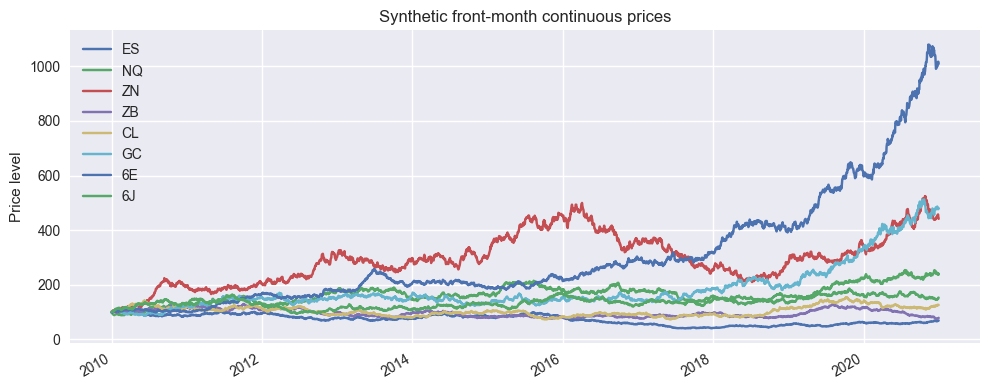

In [6]:
ax = prices.plot(figsize=(10, 4), title="Synthetic front-month continuous prices")
ax.set_ylabel("Price level")
plt.tight_layout()

## 2. Run the baseline backtest

With the data validated, we trigger the daily event-loop backtester. The result bundle
contains NAV, trade logs, ledger information, and the deterministic configuration hash.

In [7]:
from tf.eval.metrics import compute_rolling_metrics, performance_summary

result = backtester.run(check_reproducibility=True)
summary = performance_summary(result.nav, pnl=result.pnl, trades=result.trades)

print(f"Config hash: {result.config_hash}")
pd.Series(summary)

Config hash: 36dc6c2e1df0d3965a0aa9e50336a3a968b8adda789ab84aa328a8f4eb32f73c


CAGR           -0.0043
Volatility      0.0131
Sharpe         -0.3256
Sortino        -0.3134
Max Drawdown   -0.1113
Calmar         -0.0389
Skew           -0.0821
Kurtosis        0.4293
Turnover       30.9595
Hit Rate        0.4820
dtype: float64

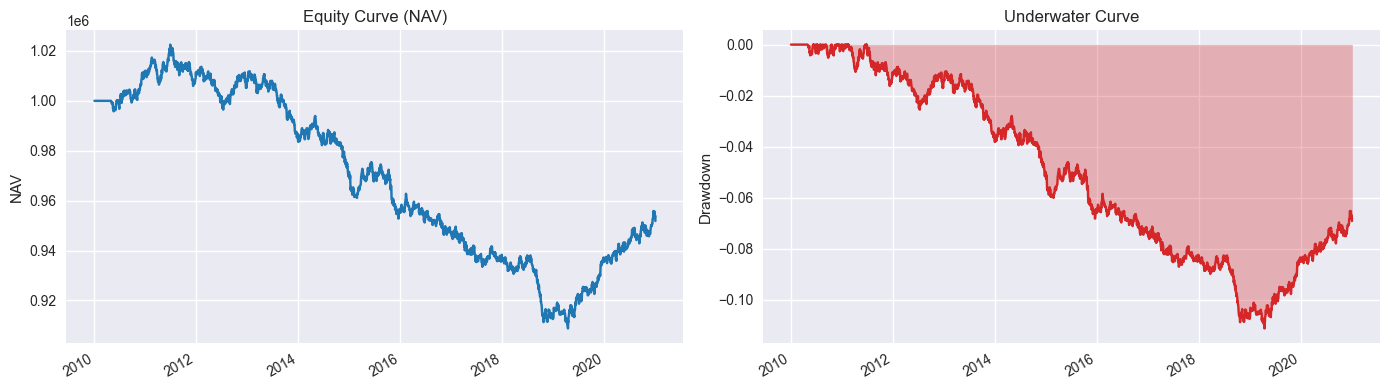

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
result.nav.plot(ax=axes[0], color="#1f77b4", title="Equity Curve (NAV)")
axes[0].set_ylabel("NAV")

running_max = result.nav.cummax()
underwater = result.nav / running_max - 1.0
underwater.plot(ax=axes[1], color="#d62728", title="Underwater Curve")
axes[1].fill_between(underwater.index, underwater, 0.0, color="#d62728", alpha=0.3)
axes[1].set_ylabel("Drawdown")
plt.tight_layout()

## 3. Attribution, exposures, and diagnostics

The evaluation toolkit computes instrument/sector contributions, exposures, rolling
statistics, and distribution diagnostics. These artefacts drive the HTML/PDF reports
emitted by the CLI.

Top-line attribution: instrument vs sector


,PnL
ZB,"-22,153.9334"
NQ,"20,658.4321"
CL,"-13,582.0388"
ES,"8,307.6892"
GC,"1,619.6006"
ZN,0.0000
6E,0.0000
6J,0.0000


,Sector PnL
Equities,"28,966.1213"
Rates,"-22,153.9334"
Commodities,"-11,962.4382"
FX,0.0000


Roll cost summary


,amount
ledger_trading,"43,020.0000"
ledger_roll,0.0000
ledger_total,"43,020.0000"
trades_rebalance,"43,020.0000"


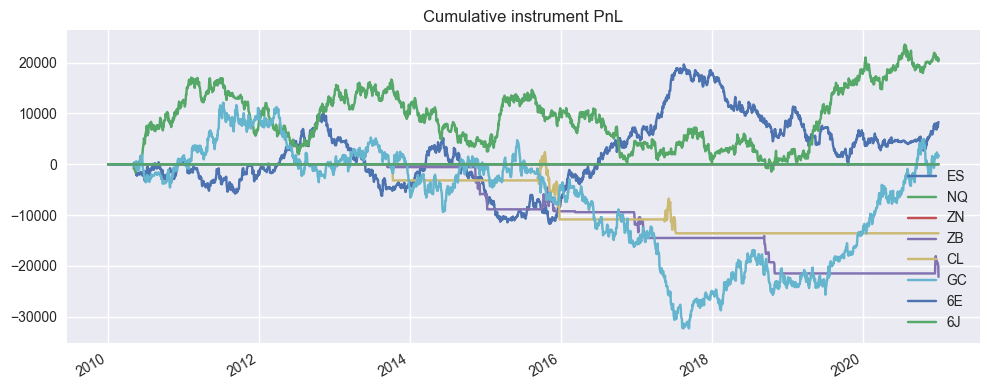

In [9]:
from tf.eval.analytics import (
    compute_exposures,
    compute_pnl_contributions,
    compute_roll_cost_breakdown,
    compute_sector_contributions,
    normalise_totals,
)

contrib = compute_pnl_contributions(result.prices, result.positions, result.point_values)
sector_contrib = compute_sector_contributions(contrib, result.sector_map)
exposure = compute_exposures(result.prices, result.positions, result.point_values)
roll_costs = compute_roll_cost_breakdown(result.trades, result.costs)
rolling = compute_rolling_metrics(result.nav, window=126)

print("Top-line attribution: instrument vs sector")
display(normalise_totals(contrib.sum()).to_frame("PnL"))
display(sector_contrib.sum().to_frame("Sector PnL"))
print("Roll cost summary")
display(roll_costs)

contrib.cumsum().plot(figsize=(10, 4), title="Cumulative instrument PnL")
plt.tight_layout()

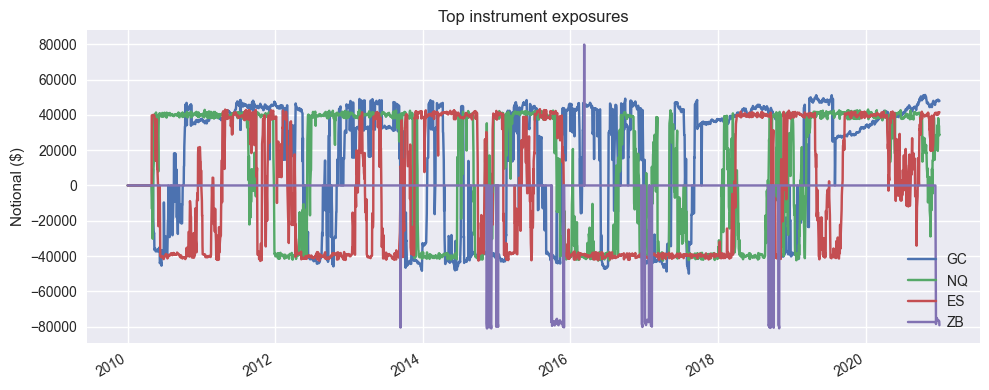

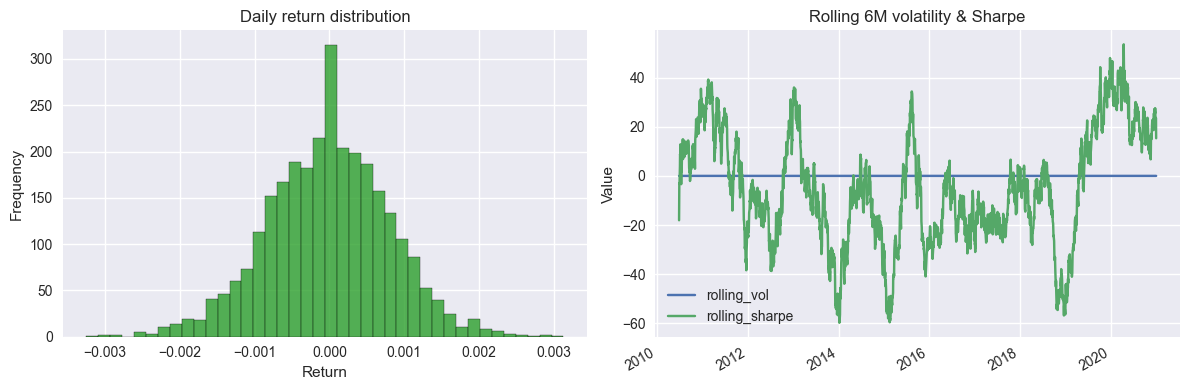

In [10]:
if not exposure.empty:
    top = exposure.abs().mean().sort_values(ascending=False).head(4).index
    exposure[top].plot(figsize=(10, 4), title="Top instrument exposures")
    plt.ylabel("Notional ($)")
    plt.tight_layout()

returns = result.nav.pct_change().dropna()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
returns.plot.hist(ax=axes[0], bins=40, alpha=0.8, color="#2ca02c", edgecolor="black")
axes[0].set_title("Daily return distribution")
axes[0].set_xlabel("Return")

rolling.plot(ax=axes[1], title="Rolling 6M volatility & Sharpe")
axes[1].set_ylabel("Value")
plt.tight_layout()

## 4. Parameter grid search

We can sweep configuration parameters via :func:`tf.api.run_parameter_sweep`. Below we
try a handful of lookback combinations and compare the resulting Sharpe ratios.

In [11]:
parameter_grid = {
    "signals.momentum.lookbacks": [
        [63],
        [126],
        [252],
        [63, 126, 252],
    ]
}

sweep_results, _ = api.run_parameter_sweep(
    CONFIG_PATH,
    parameter_grid=parameter_grid,
    seeds=[context.config.get("backtest", {}).get("seed", 42)],
)

records = []
for idx, item in enumerate(sweep_results, start=1):
    metrics = performance_summary(item.backtest.nav)
    records.append({
        "scenario": idx,
        "lookbacks": item.scenario.grid_overrides.get("signals", {})
        if item.scenario.grid_overrides
        else None,
        "Sharpe": metrics["Sharpe"],
        "CAGR": metrics["CAGR"],
    })

pd.DataFrame(records).set_index("scenario")

,lookbacks,Sharpe,CAGR
scenario,,,
1,{'momentum': {'lookbacks': [63]}},-0.3855,-0.0051
2,{'momentum': {'lookbacks': [126]}},-0.4213,-0.0057
3,{'momentum': {'lookbacks': [252]}},-0.2352,-0.0031
4,"{'momentum': {'lookbacks': [63, 126, 252]}}",-0.3256,-0.0043


## 5. Walk-forward evaluation

Walk-forward studies split the history into sequential in-sample and out-of-sample
folds. This mirrors the robustness tooling delivered in Phase 7.

In [12]:
wf_results, _ = api.run_walk_forward(
    CONFIG_PATH,
    insample=756,
    oos=252,
    step=252,
    seed=context.config.get("backtest", {}).get("seed", 42),
)

wf_records = []
for idx, wf in enumerate(wf_results, start=1):
    record = {
        "fold": idx,
        "train_start": str(wf.window.insample_start.date()),
        "train_end": str(wf.window.insample_end.date()),
        "test_start": str(wf.window.oos_start.date()),
        "test_end": str(wf.window.oos_end.date()),
    }
    record.update({f"IS_{k}": v for k, v in wf.insample_summary.items()})
    record.update({f"OOS_{k}": v for k, v in wf.oos_summary.items()})
    wf_records.append(record)

pd.DataFrame(wf_records).set_index("fold")

,train_start,train_end,test_start,test_end,IS_CAGR,IS_Volatility,IS_Sharpe,IS_Sortino,IS_Max Drawdown,IS_Calmar,...,OOS_CAGR,OOS_Volatility,OOS_Sharpe,OOS_Sortino,OOS_Max Drawdown,OOS_Calmar,OOS_Skew,OOS_Kurtosis,OOS_Turnover,OOS_Hit Rate
fold,,,,,,,,,,,,,,,,,,,,,
1,2010-01-01,2012-11-23,2012-11-26,2013-11-12,0.0034,0.0113,0.3060,0.3067,-0.0255,0.1335,...,-0.0179,0.0125,-1.4347,-1.3816,-0.0192,-0.9290,-0.1056,-0.1527,0.0000,0.4582
2,2010-01-01,2013-11-12,2013-11-13,2014-10-30,-0.0018,0.0116,-0.1533,-0.1512,-0.0295,-0.0627,...,-0.0103,0.0126,-0.8218,-0.7980,-0.0120,-0.8603,0.2039,0.4434,0.0000,0.5060
3,2010-01-01,2014-10-30,2014-10-31,2015-10-19,-0.0034,0.0118,-0.2860,-0.2809,-0.0397,-0.0868,...,-0.0146,0.0140,-1.0450,-0.9392,-0.0218,-0.6710,-0.3594,-0.2385,0.0000,0.5100
4,2010-01-01,2015-10-19,2015-10-20,2016-10-05,-0.0054,0.0122,-0.4357,-0.4189,-0.0601,-0.0894,...,-0.0145,0.0139,-1.0442,-0.9704,-0.0194,-0.7472,-0.3134,1.8039,0.0000,0.4940
5,2010-01-01,2016-10-05,2016-10-06,2017-09-22,-0.0066,0.0124,-0.5276,-0.5035,-0.0711,-0.0931,...,-0.0173,0.0146,-1.1919,-1.1451,-0.0216,-0.8030,0.0752,0.3242,0.0000,0.4900
6,2010-01-01,2017-09-22,2017-09-25,2018-09-11,-0.0080,0.0127,-0.6265,-0.5980,-0.0870,-0.0921,...,-0.0117,0.0127,-0.9180,-0.9161,-0.0159,-0.7351,0.1909,0.0093,0.0000,0.4781
7,2010-01-01,2018-09-11,2018-09-12,2019-08-29,-0.0084,0.0127,-0.6588,-0.6320,-0.0937,-0.0899,...,-0.0024,0.0147,-0.1538,-0.1482,-0.0193,-0.1223,-0.1542,-0.0463,0.0000,0.5060
8,2010-01-01,2019-08-29,2019-08-30,2020-08-17,-0.0079,0.0129,-0.6042,-0.5799,-0.1113,-0.0706,...,0.0213,0.0139,1.5181,1.4475,-0.0052,4.0890,-0.3882,0.5674,0.0000,0.5657


## 6. Monte-Carlo confidence intervals

Block bootstrap resampling quantifies the distribution of key performance metrics by
respecting the serial correlation structure of returns.

In [13]:
from tf.research.monte_carlo import bootstrap_confidence_intervals

returns = result.nav.pct_change().dropna()
ci = bootstrap_confidence_intervals(
    returns,
    metrics=["sharpe", "max_drawdown"],
    n_samples=500,
    block_size=20,
    seed=123,
)

pd.DataFrame({name: vars(interval) for name, interval in ci.items()})

,sharpe,max_drawdown
mean,-0.3074,-0.0748
lower,-0.8798,-0.1356
upper,0.2587,-0.0312


## 7. Sensitivity analysis utilities

The research helpers make it easy to profile how performance responds to configuration
changes without hand-writing nested loops.

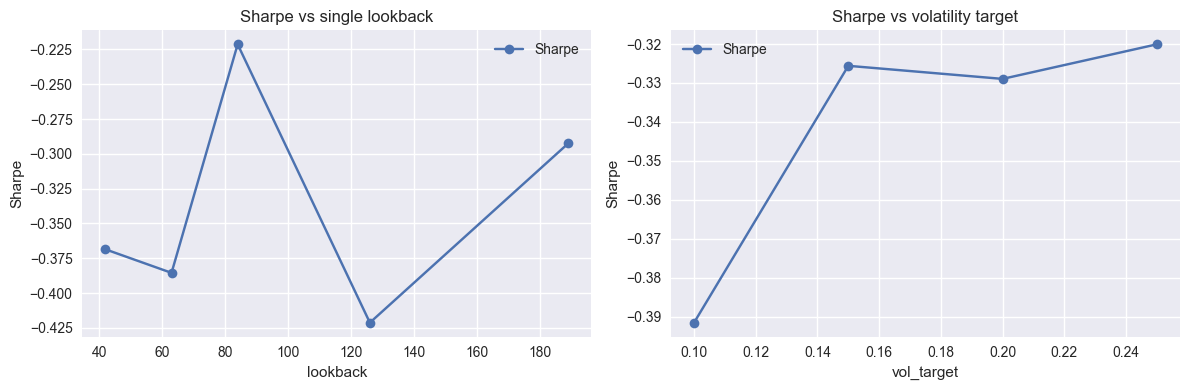

In [14]:
from tf.research import sensitivity

lookback_curve = sensitivity.lookback_sensitivity(
    backtester,
    lookbacks=[42, 63, 84, 126, 189],
    seed=42,
)
vol_curve = sensitivity.vol_target_sensitivity(
    backtester,
    targets=[0.10, 0.15, 0.20, 0.25],
    seed=42,
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
lookback_curve.plot(ax=axes[0], marker="o", title="Sharpe vs single lookback")
axes[0].set_ylabel("Sharpe")
vol_curve.plot(ax=axes[1], marker="o", title="Sharpe vs volatility target")
axes[1].set_ylabel("Sharpe")
plt.tight_layout()

## 8. Wrap-up

All artefacts generated in this notebook (NAV, trades, ledger, charts, and summary
statistics) mirror the CLI outputs stored under the configured ``results/`` directory.
Experiment with additional parameter grids, alternative universes, or plug in live data
feeds to extend the workflow further.